# Introduction

The quality of wine is influenced by many elements, such as the type of grape or fruit used, how it was fermented, storage and aging techniques, and the climate and location where it was grown. Wines can be divided into different categories based on factors such as taste, smell, and color, with varying levels of quality ranging from common table wines to top-quality fine wines.

The objective of wine quality prediction is to create models using data that can accurately forecast the quality of a wine, thereby assisting winemakers, wine growers, and retailers in making informed decisions about their products.

First, we will perform a data analysis on the `train` and `original` datasets to identify underlying patterns. Then, multiple models will be trained on the dataset to predict the quality of wine in the unseen `test` data.

# Data

In [1]:
# Load libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import GridSearchCV, StratifiedKFold, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from sklearn.metrics import cohen_kappa_score, make_scorer
from sklearn.ensemble import VotingClassifier

colors = ["#0091AD", "#9CEAEF"]
pal = sns.set_palette(sns.color_palette(colors))

In [2]:
df_train = pd.read_csv('/kaggle/input/playground-series-s3e5/train.csv')
df_test = pd.read_csv('/kaggle/input/playground-series-s3e5/test.csv')
df_orig = pd.read_csv('/kaggle/input/wine-quality-dataset/WineQT.csv')

In [3]:
# Basic Information about original dataset
df_orig.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
 12  Id                    1143 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 116.2 KB


In [4]:
# Basic Information about train dataset
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2056 entries, 0 to 2055
Data columns (total 13 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    2056 non-null   int64  
 1   fixed acidity         2056 non-null   float64
 2   volatile acidity      2056 non-null   float64
 3   citric acid           2056 non-null   float64
 4   residual sugar        2056 non-null   float64
 5   chlorides             2056 non-null   float64
 6   free sulfur dioxide   2056 non-null   float64
 7   total sulfur dioxide  2056 non-null   float64
 8   density               2056 non-null   float64
 9   pH                    2056 non-null   float64
 10  sulphates             2056 non-null   float64
 11  alcohol               2056 non-null   float64
 12  quality               2056 non-null   int64  
dtypes: float64(11), int64(2)
memory usage: 208.9 KB


In [5]:
# Basic Information about test dataset
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1372 entries, 0 to 1371
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    1372 non-null   int64  
 1   fixed acidity         1372 non-null   float64
 2   volatile acidity      1372 non-null   float64
 3   citric acid           1372 non-null   float64
 4   residual sugar        1372 non-null   float64
 5   chlorides             1372 non-null   float64
 6   free sulfur dioxide   1372 non-null   float64
 7   total sulfur dioxide  1372 non-null   float64
 8   density               1372 non-null   float64
 9   pH                    1372 non-null   float64
 10  sulphates             1372 non-null   float64
 11  alcohol               1372 non-null   float64
dtypes: float64(11), int64(1)
memory usage: 128.8 KB


**Insights:**

* The `original` dataset contains 1143 samples with no missing values.

* The `train` dataset contains 2056 samples with no missing values.

* The `test` dataset has 1372 non-null observations.

* The features found in these datasets include: fixed acidity (g/L), volatile acidity (g/L), citric acid (g/L), residual sugar (g/L), chlorides (g/L), free sulfur dioxide (mg/L), total sulfur dioxide (mg/L), density (g/mL), pH, sulphates (g/L), and alcohol content (% vol.)

In [6]:
# Rearrange the original dataset columns to align with train dataset
change_cols = list(df_train.columns)
df_orig = df_orig.reindex(columns=change_cols)

# EDA

In [7]:
# Join original and train datasets for exploratory data analysis
df = pd.concat([df_orig.assign(frame='Original'), df_train.assign(frame='Train')])
df = df.reset_index(drop=True)

In [8]:
df.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality,frame
0,0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Original
1,1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5,Original
2,2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5,Original
3,3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6,Original
4,4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5,Original


In [9]:
# Information about the concatenated dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3199 entries, 0 to 3198
Data columns (total 14 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Id                    3199 non-null   int64  
 1   fixed acidity         3199 non-null   float64
 2   volatile acidity      3199 non-null   float64
 3   citric acid           3199 non-null   float64
 4   residual sugar        3199 non-null   float64
 5   chlorides             3199 non-null   float64
 6   free sulfur dioxide   3199 non-null   float64
 7   total sulfur dioxide  3199 non-null   float64
 8   density               3199 non-null   float64
 9   pH                    3199 non-null   float64
 10  sulphates             3199 non-null   float64
 11  alcohol               3199 non-null   float64
 12  quality               3199 non-null   int64  
 13  frame                 3199 non-null   object 
dtypes: float64(11), int64(2), object(1)
memory usage: 350.0+ KB


In [10]:
# Descriptive Statistics
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Id,3199.0,947.989997,561.003902,0.00000,468.50000,936.0000,1402.5000,2055.00000
fixed acidity,3199.0,8.345858,1.720511,4.60000,7.10000,7.9000,9.1000,15.90000
volatile acidity,3199.0,0.528936,0.175484,0.12000,0.39000,0.5200,0.6400,1.58000
citric acid,3199.0,0.266239,0.191294,0.00000,0.09000,0.2500,0.4200,1.00000
residual sugar,3199.0,2.446499,1.065161,0.90000,1.90000,2.2000,2.6000,15.50000
chlorides,3199.0,0.083670,0.034140,0.01200,0.07100,0.0790,0.0900,0.61100
free sulfur dioxide,3199.0,16.477024,10.115222,1.00000,7.00000,15.0000,23.0000,68.00000
total sulfur dioxide,3199.0,48.049859,32.930681,6.00000,22.00000,42.0000,64.0000,289.00000
density,3199.0,0.996742,0.001863,0.99007,0.99558,0.9967,0.9978,1.00369
pH,3199.0,3.310728,0.147582,2.74000,3.20000,3.3100,3.3900,4.01000


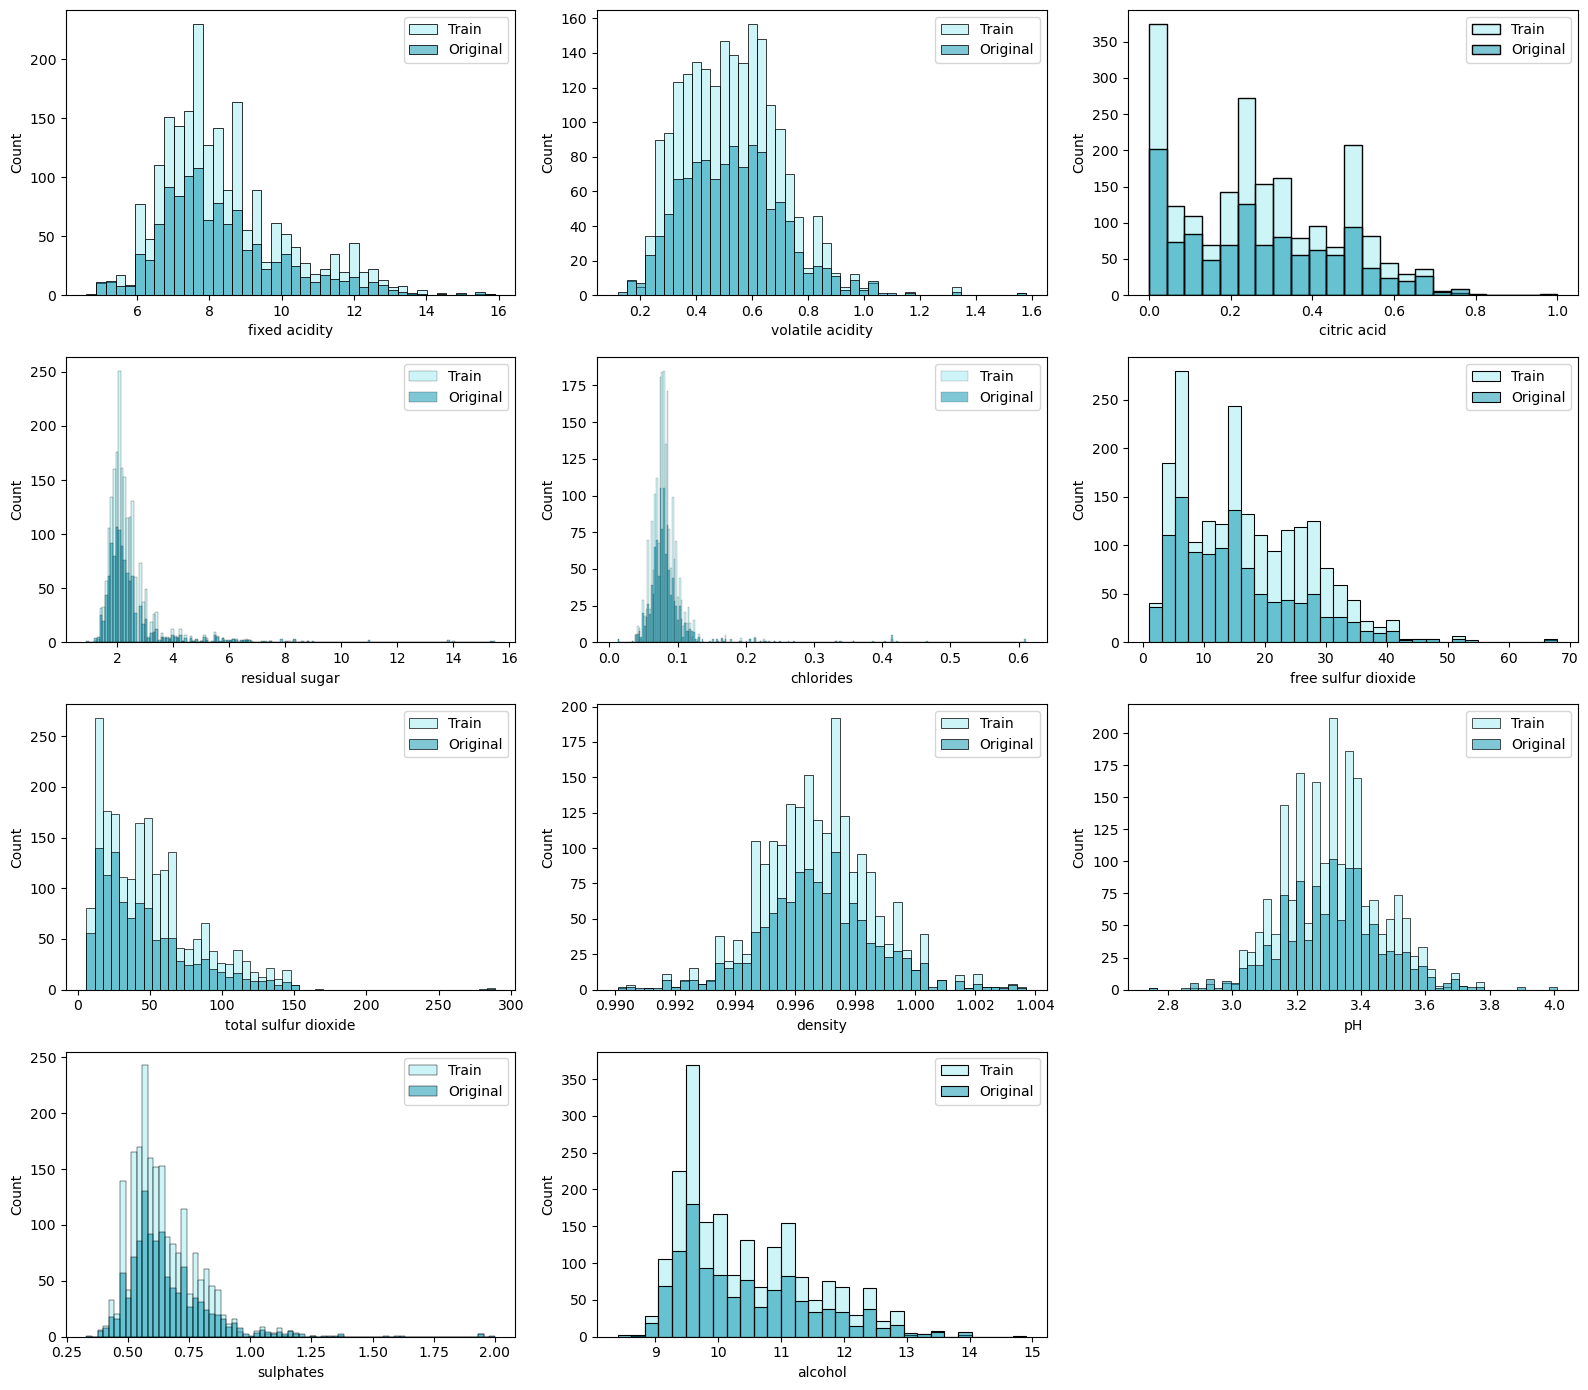

In [11]:
float_cols = list(df.select_dtypes('float').columns)

fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 14), dpi=100)
for col, ax in zip(float_cols, axes.ravel()):
    sns.histplot(data=df, x=col, hue='frame', ax=ax, palette=pal)
    ax.legend(['Train', 'Original'], title='')
fig.delaxes(axes[3, -1])
plt.tight_layout()

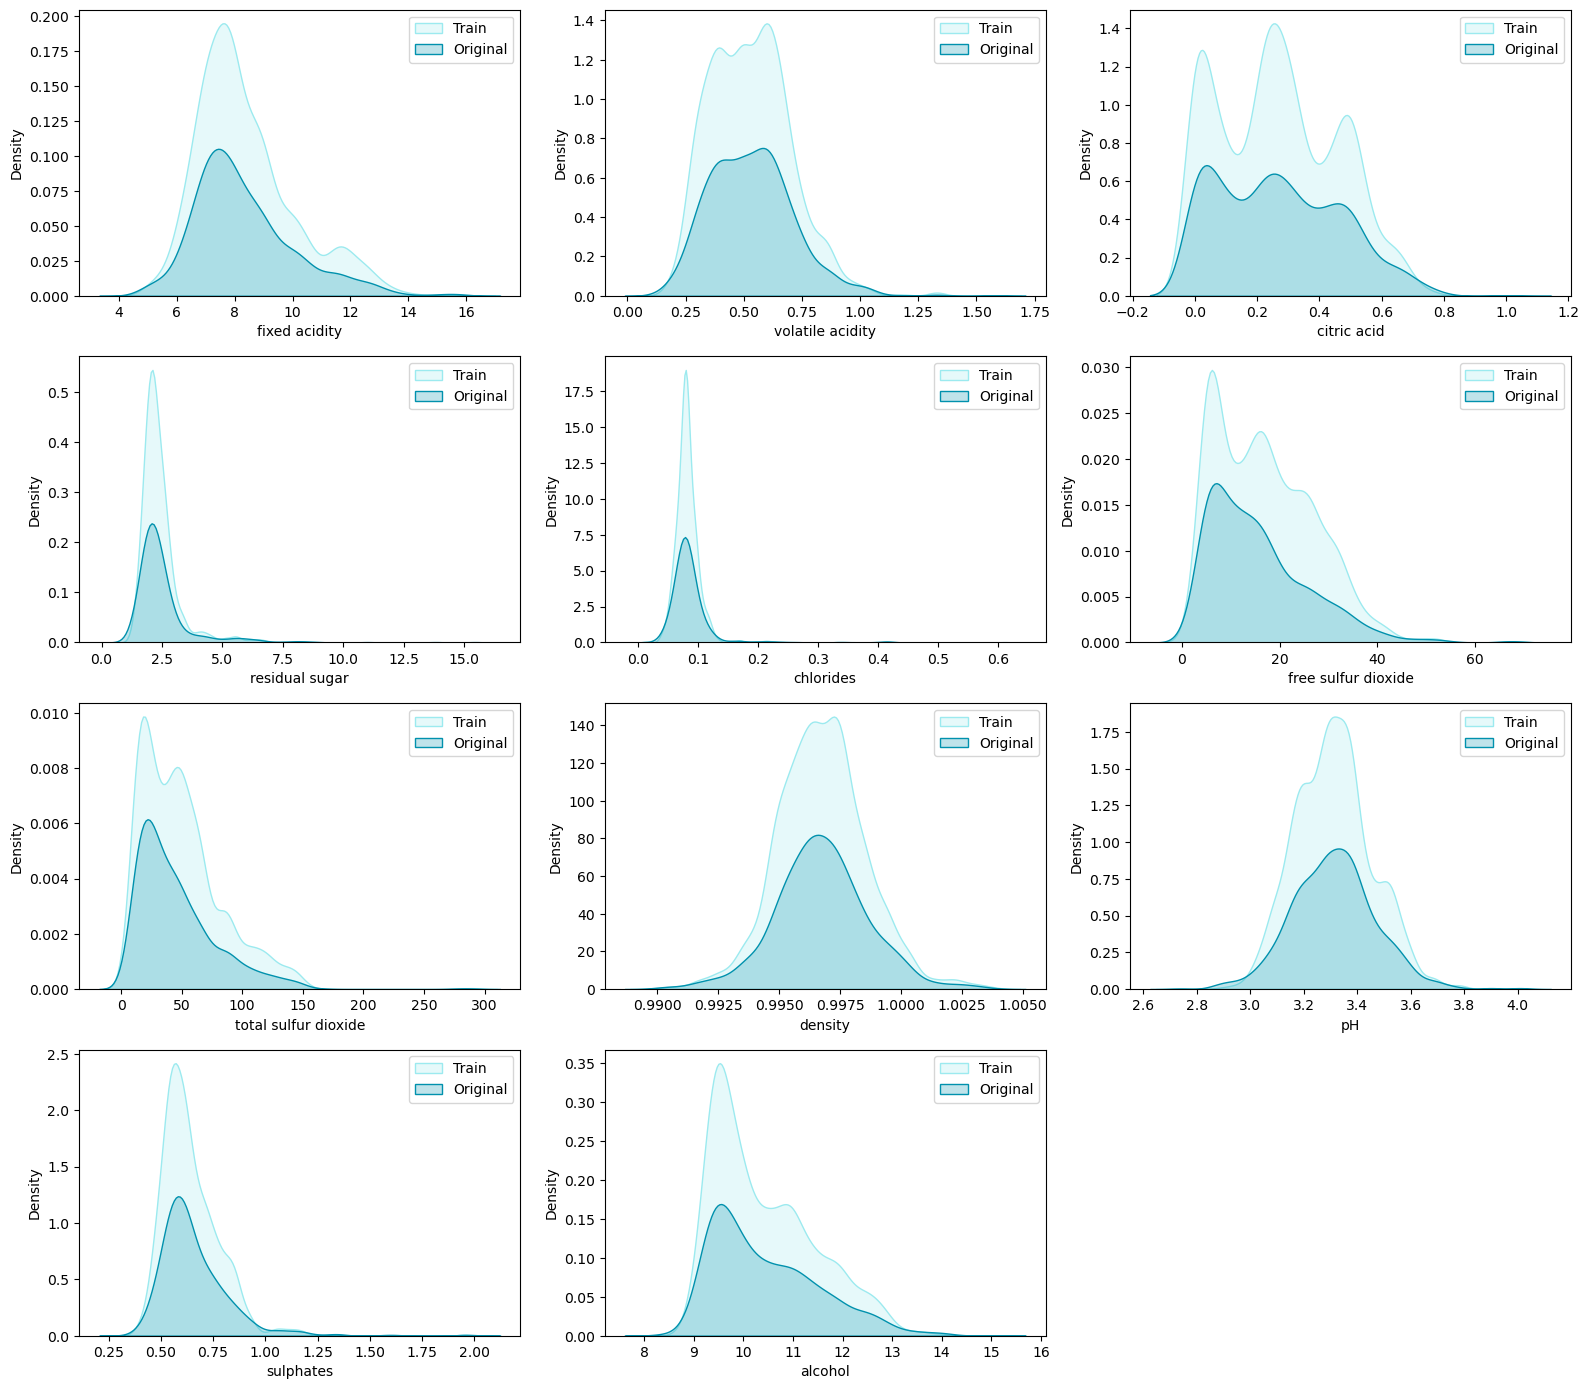

In [12]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 14), dpi=100)
for col, ax in zip(float_cols, axes.ravel()):
    sns.kdeplot(data=df, x=col, hue='frame', ax=ax, fill=True, palette=pal)
    ax.legend(['Train', 'Original'], title='')
fig.delaxes(axes[3, -1])
plt.tight_layout()

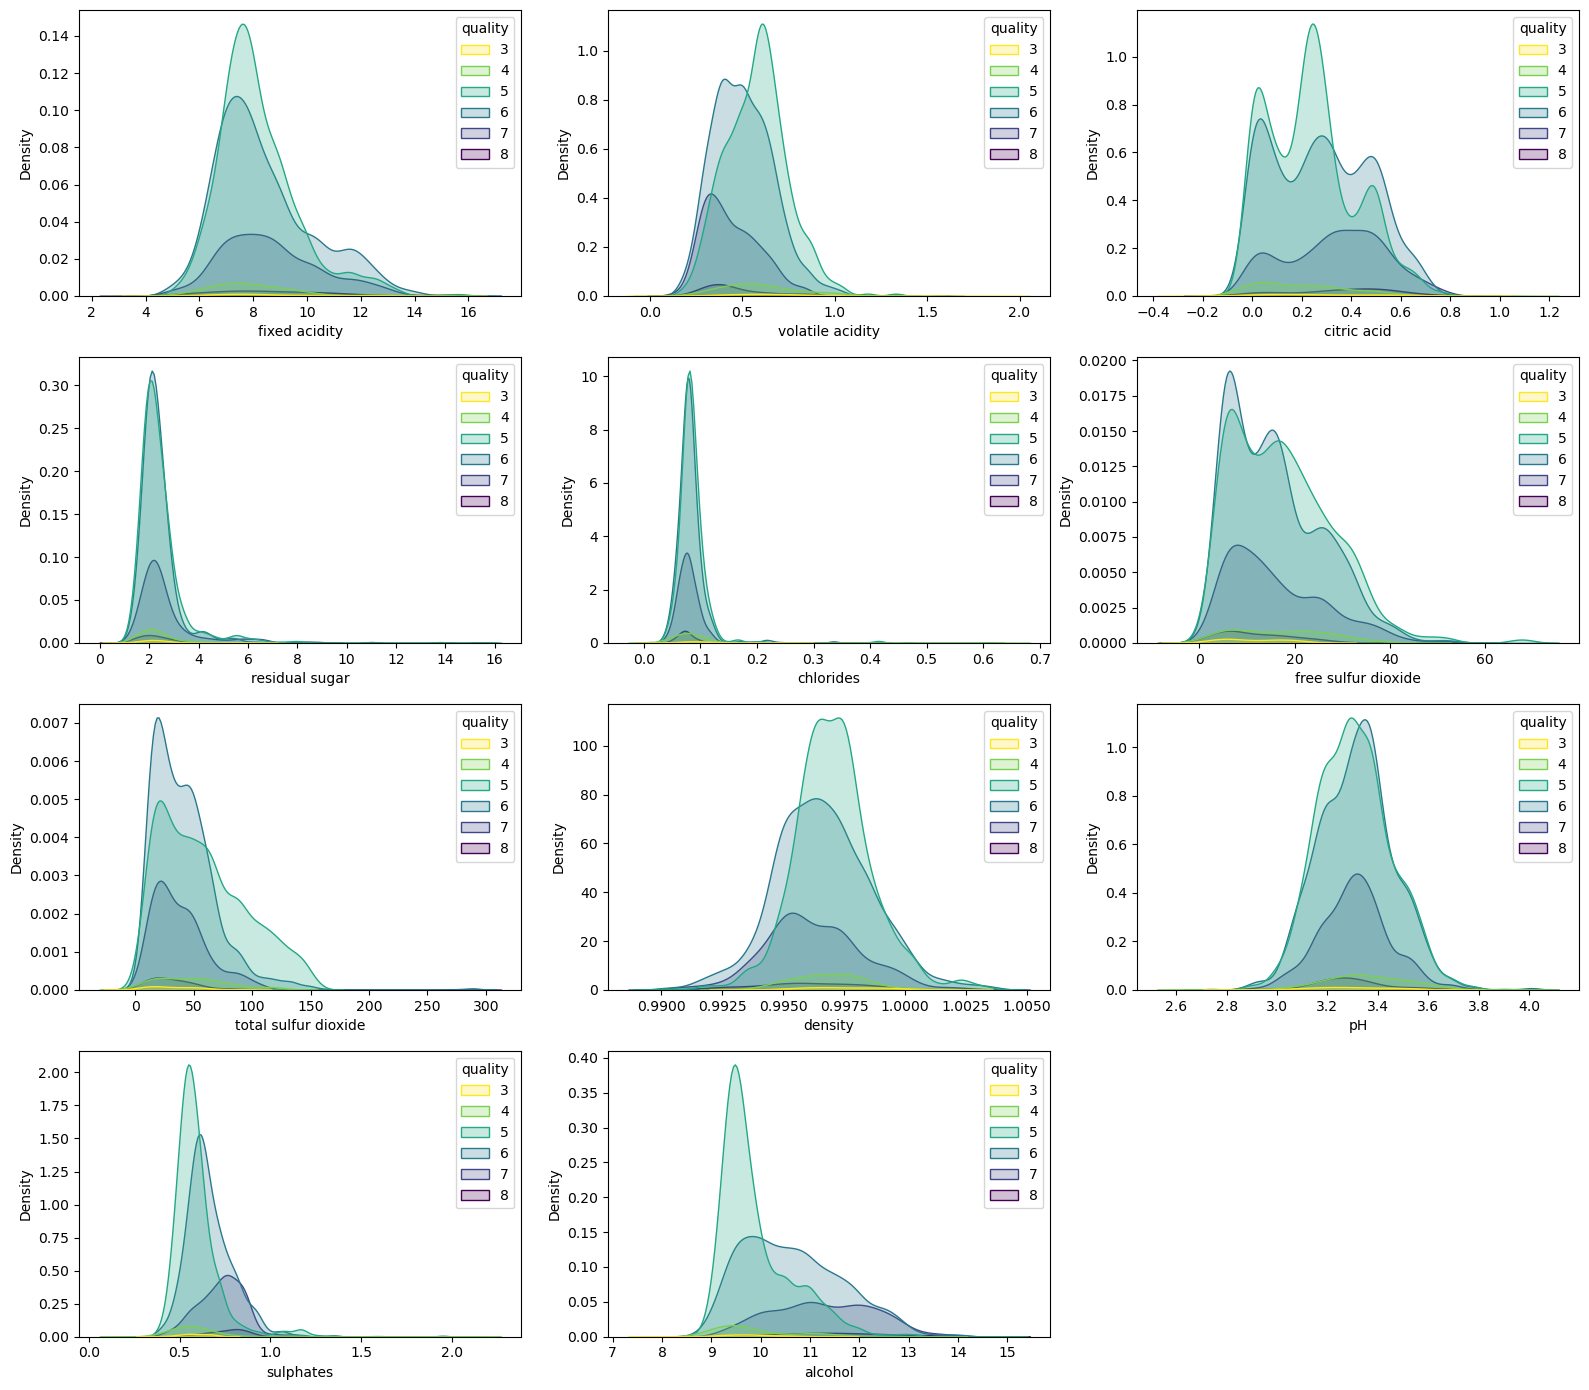

In [13]:
fig, axes = plt.subplots(nrows=4, ncols=3, figsize=(16, 14), dpi=100)
for col, ax in zip(float_cols, axes.ravel()):
    sns.kdeplot(data=df, x=col, ax=ax, hue='quality', palette='viridis_r', fill=True)
fig.delaxes(axes[3, -1])
plt.tight_layout()

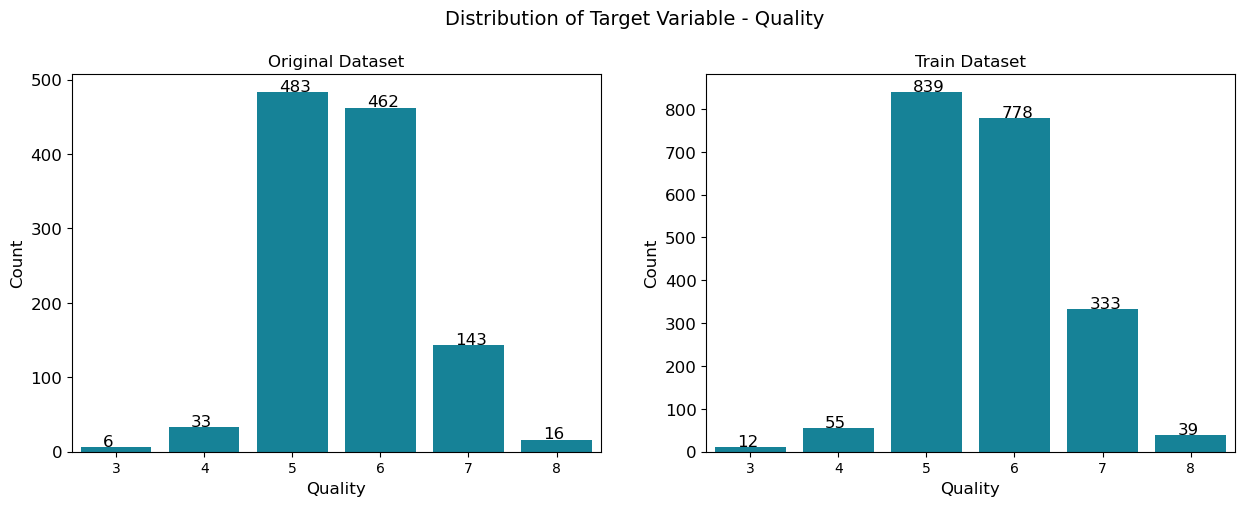

In [14]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5), dpi=100)
fig.suptitle("Distribution of Target Variable - Quality", fontsize=14, y=1.01)

sns.countplot(data=df_orig, x='quality', color=colors[0], ax=ax1)
ax1.set_title('Original Dataset', fontsize=12, y=1.00)
ax1.set_xlabel('Quality', fontsize=12)
ax1.set_ylabel('Count', fontsize=12)
ax1.xaxis.set_tick_params(labelsize=10)
ax1.yaxis.set_tick_params(labelsize=12)
for p in ax1.patches:
    ax1.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+1.55), fontsize=12)


sns.countplot(data=df_train, x='quality', color=colors[0], ax=ax2)
ax2.set_title('Train Dataset', fontsize=12, y=1.00)
ax2.set_xlabel('Quality', fontsize=12)
ax2.set_ylabel('Count', fontsize=12)
ax2.xaxis.set_tick_params(labelsize=10)
ax2.yaxis.set_tick_params(labelsize=12)
for p in ax2.patches:
    ax2.annotate('{}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+1.55), fontsize=12)

**Insights:**

* The target variable "quality" has a majority of its values within the 5 and 6 categories.

* The dataset has fewer samples in the categories 3, 4, and 8.

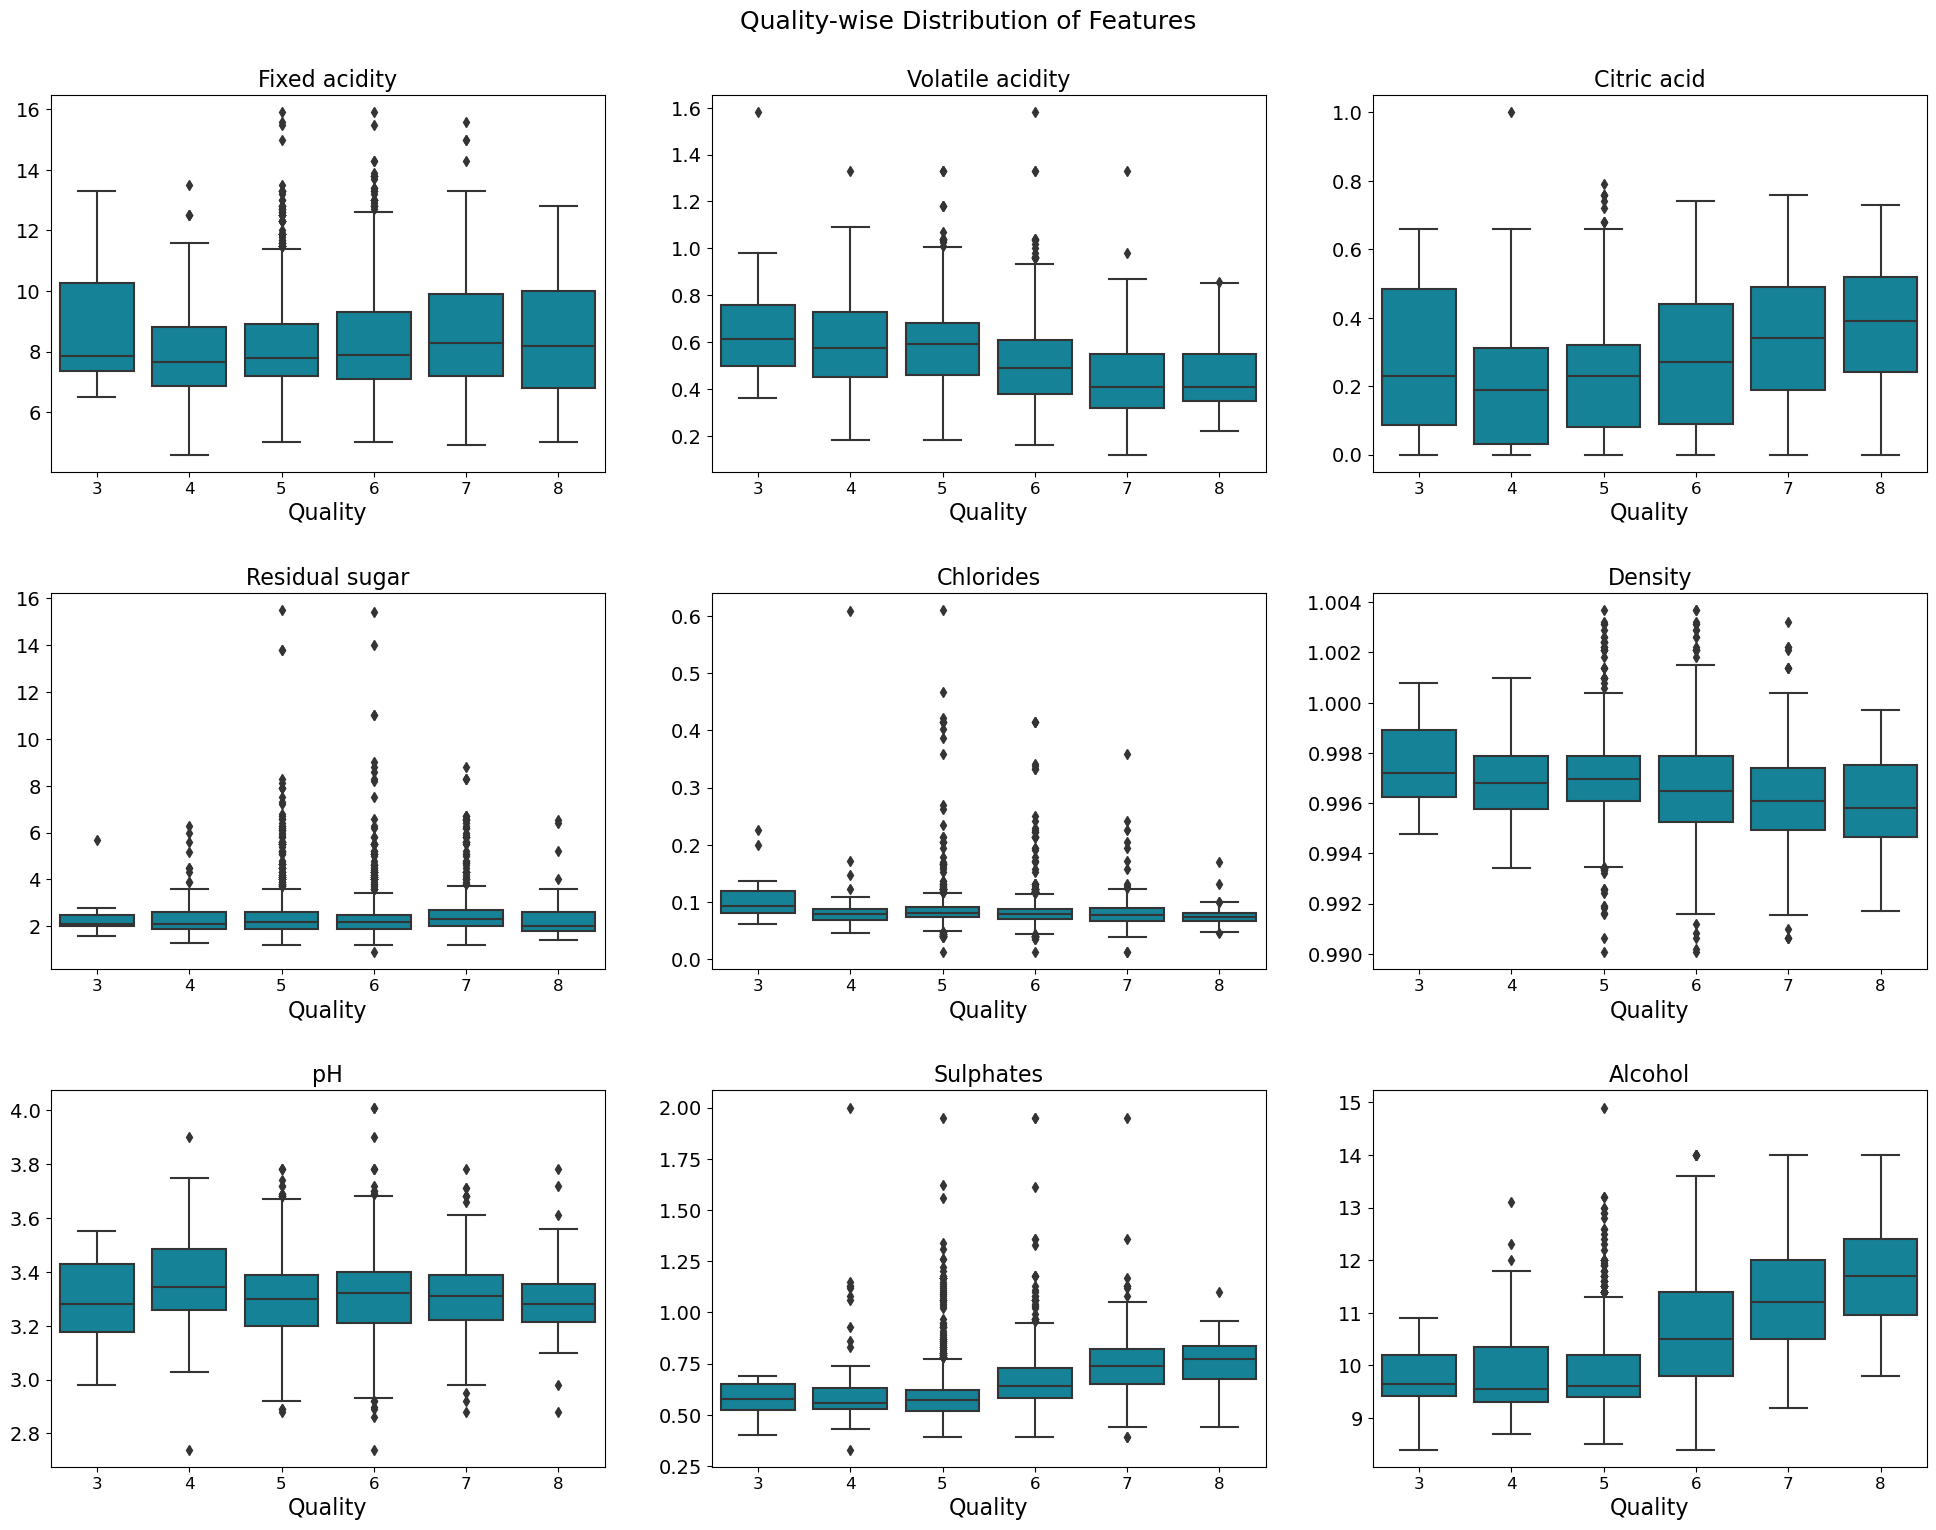

In [15]:
cols = ['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar', 
        'chlorides', 'density', 'pH', 'sulphates', 'alcohol']
labels = ['Fixed acidity', 'Volatile acidity', 'Citric acid', 'Residual sugar', 
        'Chlorides', 'Density', 'pH', 'Sulphates', 'Alcohol']
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(20, 16), dpi=100)
fig.suptitle('Quality-wise Distribution of Features', fontsize=18, y=0.97)
for col, label, ax in zip(cols, labels, axes.ravel()):
    sns.boxplot(data=df, x='quality', y=col, ax=ax, color=colors[0])
    ax.set_title(label, fontsize=16)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=14)
    ax.set_xlabel('Quality', fontsize=16)
    ax.set_ylabel('')
fig.tight_layout(pad=3)

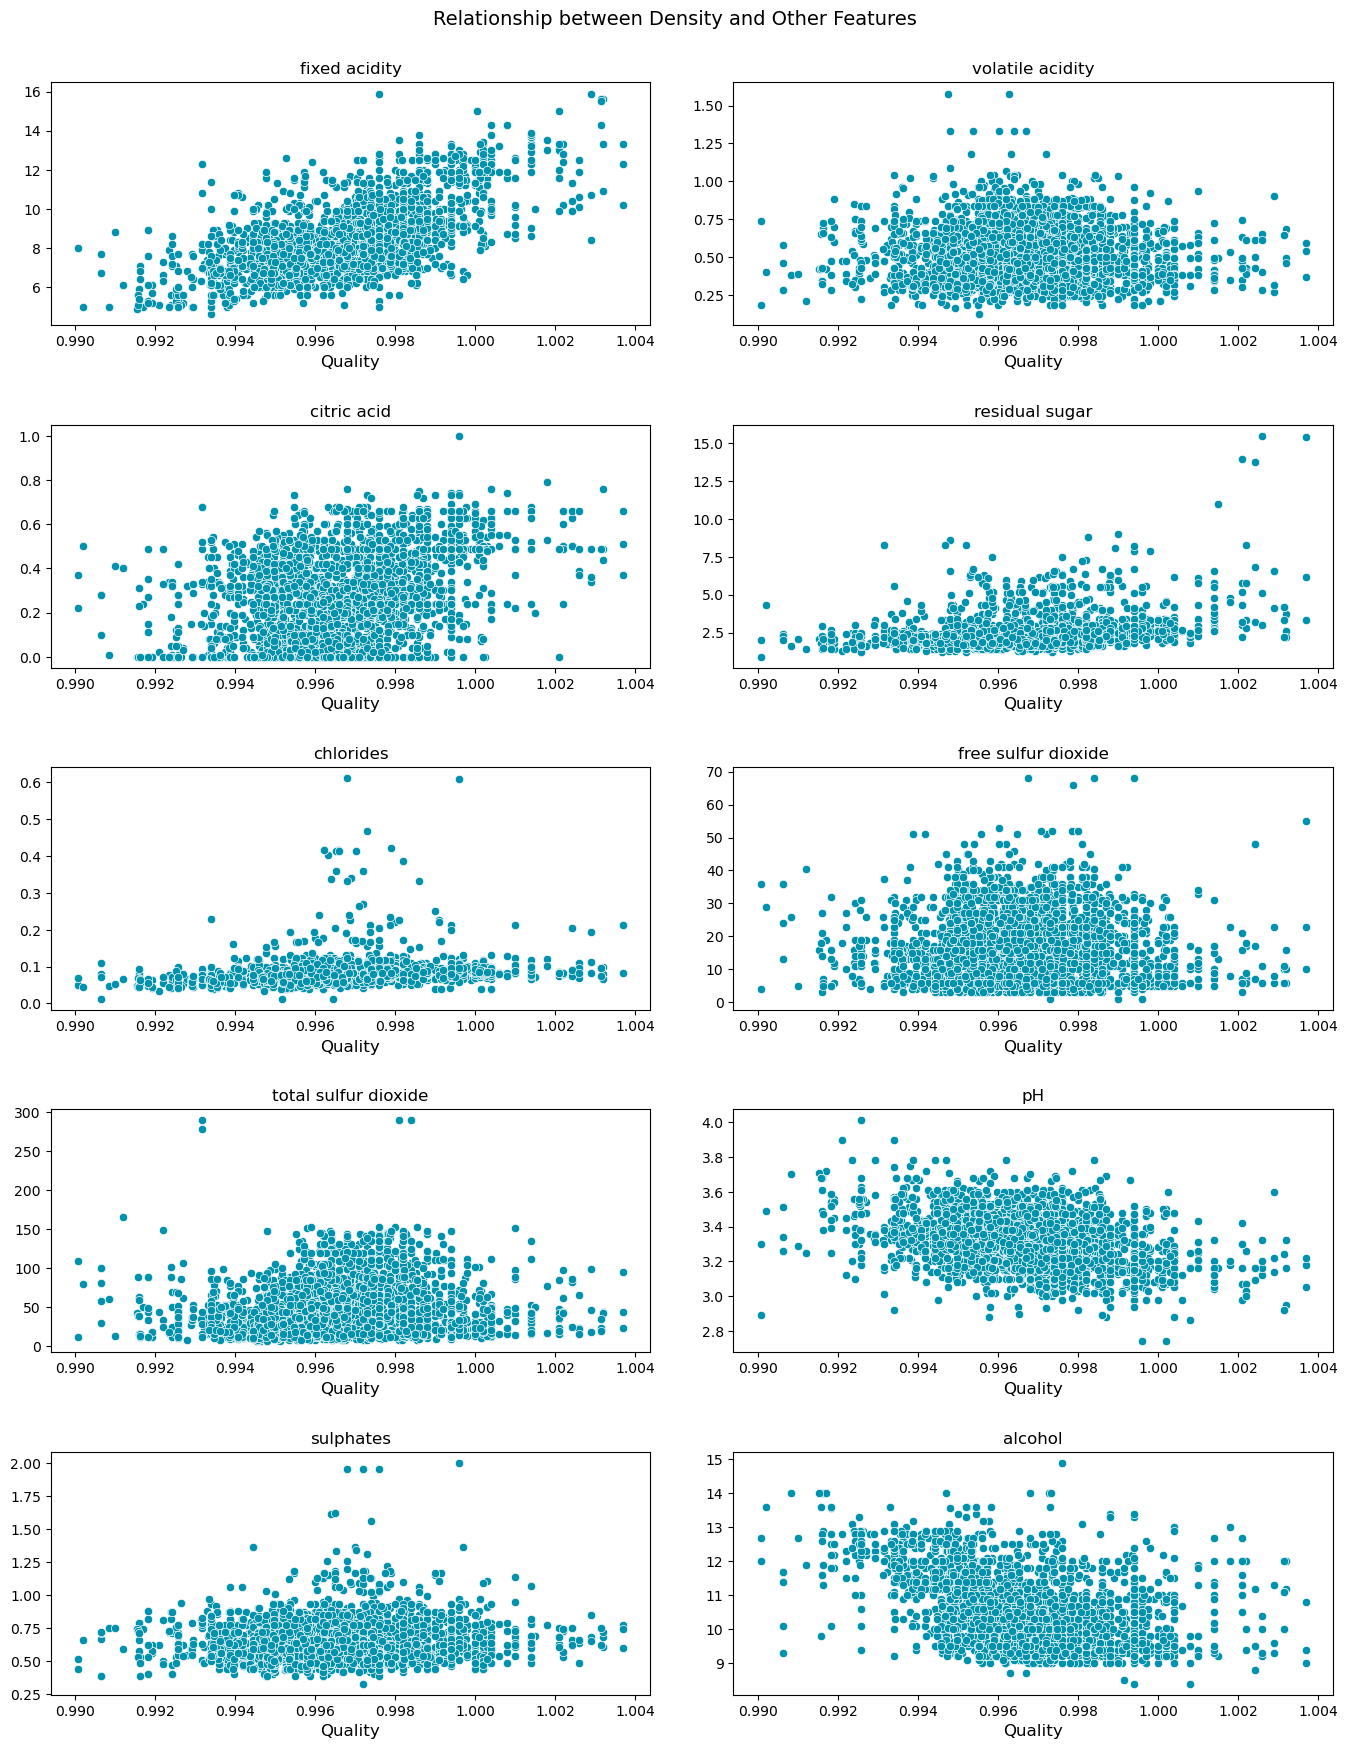

In [16]:
fcols = df.select_dtypes('float').columns
fcols = list(fcols.drop('density'))

fig, axes = plt.subplots(nrows=5, ncols=2, figsize=(14, 18), dpi=100)
fig.suptitle('Relationship between Density and Other Features', fontsize=14, y=0.98)
for col, ax in zip(fcols, axes.ravel()):
    sns.scatterplot(data=df, x='density', y=col, color=colors[0], ax=ax)
    ax.set_title(col, fontsize=12)
    ax.xaxis.set_tick_params(labelsize=10)
    ax.yaxis.set_tick_params(labelsize=10)
    ax.set_xlabel('Quality', fontsize=12)
    ax.set_ylabel('')
fig.tight_layout(pad=2.5)

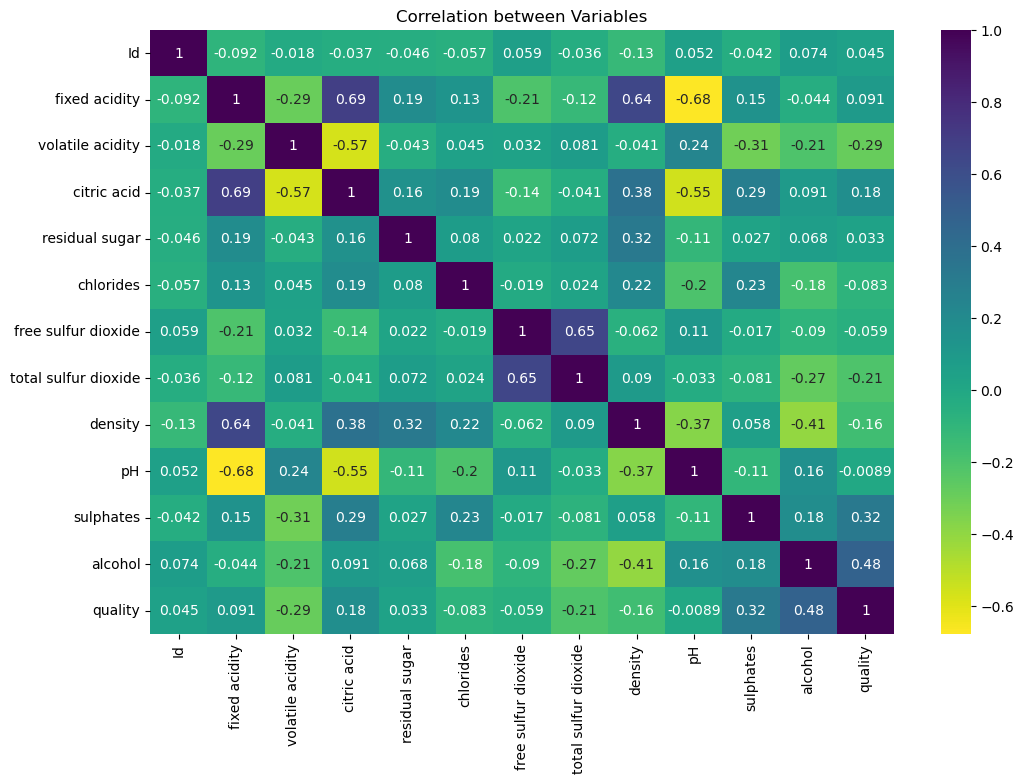

In [17]:
plt.figure(figsize=(12, 8), dpi=100)
plt.title('Correlation between Variables')
sns.heatmap(df.corr(), annot=True, cmap='viridis_r');

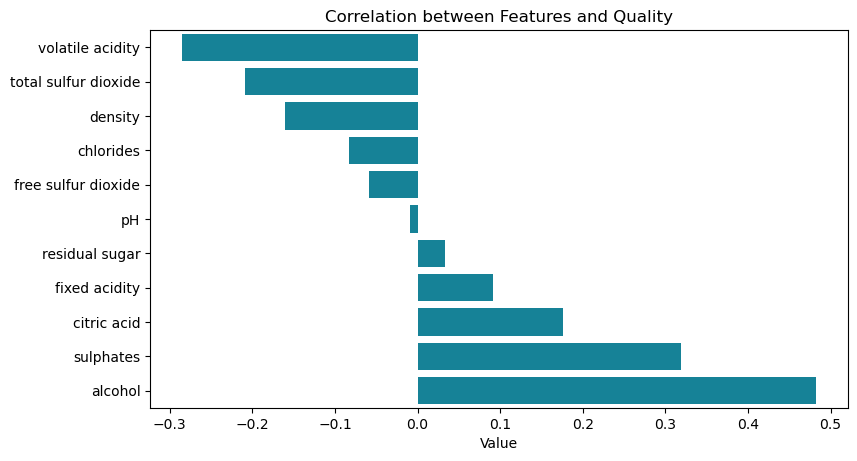

In [18]:
df_corr = df.corr()['quality'][1:].drop('quality', axis=0)

plt.figure(figsize=(9, 5), dpi=100)
plt.title('Correlation between Features and Quality')
sns.barplot(y=df_corr.sort_values().index, x=df_corr.sort_values().values, color=colors[0])
plt.xlabel('Value');

**Insights:**

* `Fixed acidity` has a correlation of 0.69 with `citric acid` and 0.64 with `density`.

* A negative correlation has been observed between `volatile acidity` and both `fixed acidity` and `citric acid`. Additionally, there is a slight positive correlation between `volatile acidity` and `pH`.

* Free SO${_2}$ and Total SO${_2}$ are strongly correlated with each other.

* The target label `quality` has positive correlation with `citric acid` (0.18), `sulphates` (0.32), and `alcohol` (0.48).

# New Features

Now we will create two new features (Bound SO${_2}$ and Molecular SO${_2}$) from the existing features to improve the predictive performance of a model. 

Sulfur dioxide (SO${_2}$) plays a significant role in wine production as it possesses a range of properties including antioxidant and antimicrobial qualities that help to preserve the wine. Free SO${_2}$ refers to sulfur dioxide that has not yet reacted with other compounds, while Bound SO${_2}$ represents sulfur dioxide that has already reacted and is no longer available for any additional functions. This "Bound SO${_2}$" can be obtained by subtracting "Free SO${_2}$" from "Total SO${_2}$", since "Total SO${_2}$" represents the sum of both "Free SO${_2}$" and "Bound SO${_2}$".

$$
\begin{aligned}
\text{Bound SO}_{2} = \text{Total SO}_{2} - \text{Free SO}_{2}
\end{aligned}
$$

The second feature we will create is the "Molecular SO${_2}$". The molecular form of SO${_2}$ plays a crucial role in preserving and protecting wine from harmful microbes. Although molecular SO${_2}$ cannot be directly measured, it can be estimated based on the wine's "pH" and the amount of "Free SO${_2}$" present in it.


$$
\begin{aligned}
\text{Molecular SO}_{2} = \frac{\text{Free SO}_{2}}{1+10^{(\text{pH} - 1.81)}}
\end{aligned}
$$

Reference: https://www.awri.com.au/wp-content/uploads/2018/03/s1886.pdf#:~:text=Sulfur%20dioxide%20exists%20as%20a,effects%20of%20SO2%20in%20wine


In [19]:
df = df.rename(columns={'free sulfur dioxide' : 'free SO2', 'total sulfur dioxide' : 'total SO2'})
df_test = df_test.rename(columns={'free sulfur dioxide' : 'free SO2', 'total sulfur dioxide' : 'total SO2'})

#Bound SO2 Calculation
df['bound SO2'] = df['total SO2'] - df['free SO2']
df_test['bound SO2'] = df_test['total SO2'] - df_test['free SO2']

# Molecular SO2 Calculation
df['molecular SO2'] = df['free SO2']/(1+10**(df['pH'] - 1.81))
df_test['molecular SO2'] = df_test['free SO2']/(1+10**(df_test['pH'] - 1.81))

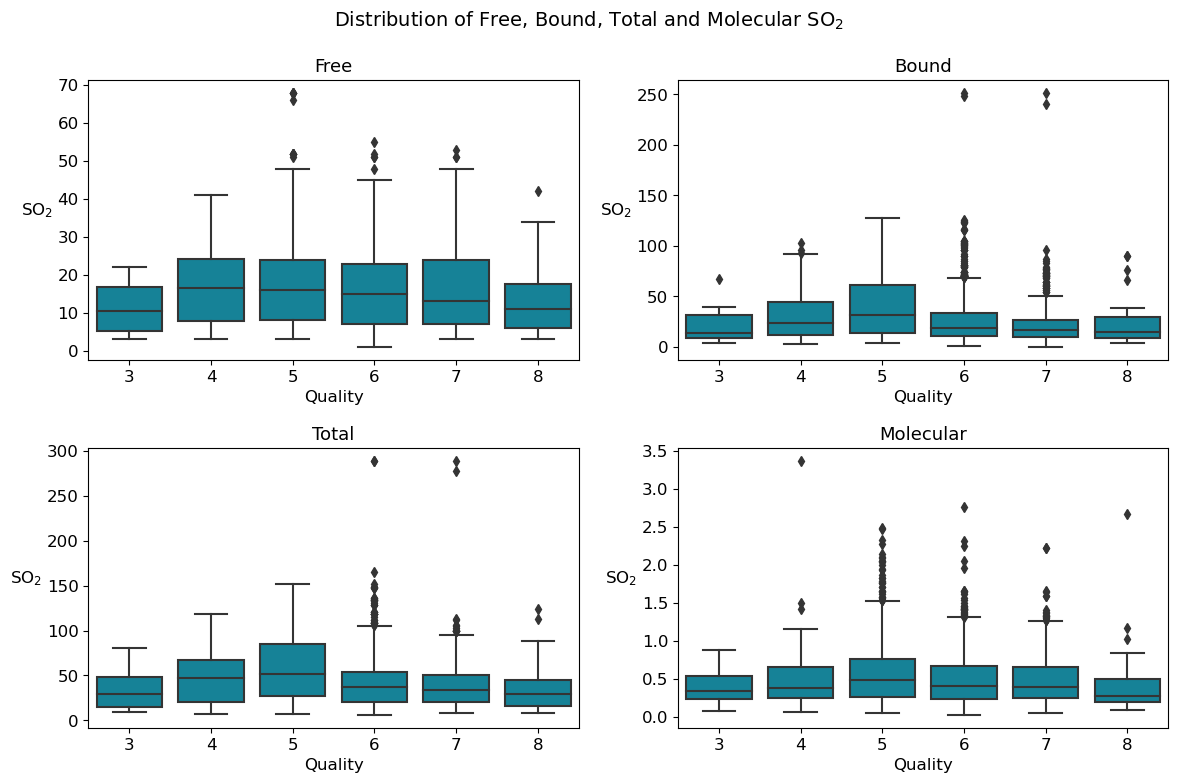

In [20]:
sc_cols = ['free SO2', 'bound SO2', 'total SO2', 'molecular SO2']
sc_labels = ['Free', 'Bound', 'Total', 'Molecular']
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 8), dpi=100)
fig.suptitle('Distribution of Free, Bound, Total and Molecular SO$_{2}$', fontsize=14, y=0.98)
for col, label, ax in zip(sc_cols, sc_labels, axes.ravel()):
    sns.boxplot(data=df, x='quality', y=col, ax=ax, color=colors[0])
    ax.set_title(label, fontsize=13)
    ax.xaxis.set_tick_params(labelsize=12)
    ax.yaxis.set_tick_params(labelsize=12)
    ax.set_xlabel('Quality', fontsize=12)
    ax.set_ylabel('SO$_{2}$', fontsize=12, rotation=360, labelpad=15)
fig.tight_layout(pad=1.5)

# Preprocessing

In [21]:
SEED = 8888
df = df.sample(frac=1, random_state=SEED).reset_index(drop=True)

In [22]:
df.head()

,Id,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free SO2,total SO2,density,pH,sulphates,alcohol,quality,frame,bound SO2,molecular SO2
0,1746,6.2,0.600,0.08,2.1,0.078,24.0,64.0,0.99640,3.38,0.49,10.2,5,Train,40.0,0.629038
1,794,6.6,0.610,0.01,2.1,0.072,34.0,46.0,0.99546,3.57,0.73,10.5,5,Train,12.0,0.580760
2,1711,8.2,0.320,0.27,1.9,0.080,21.0,58.0,0.99640,3.30,0.82,10.0,7,Train,37.0,0.658246
3,110,7.8,0.560,0.19,1.8,0.104,12.0,47.0,0.99640,3.19,0.93,9.5,5,Original,35.0,0.480224
4,1344,5.6,0.835,0.03,1.6,0.080,26.0,61.0,0.99270,3.48,0.54,12.3,8,Train,35.0,0.544235


In [23]:
# Dropping unnecessary columns
train = df.drop(['Id', 'quality', 'frame'], axis=1)
test = df_test.drop('Id', axis=1)

In [24]:
X_train = train.copy()
y_train = df['quality'] - 3
X_test = test.copy()

In [25]:
# Transforming variables to a common scale
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

X_train = pd.DataFrame(X_train, columns=train.columns)
X_test = pd.DataFrame(X_test, columns=test.columns)

print(f'Shape of X_train: {X_train.shape}')
print(f'Shape of X_test : {X_test.shape}')
print(f'Shape of y_train: {y_train.shape}')

Shape of X_train: (3199, 13)
Shape of X_test : (1372, 13)
Shape of y_train: (3199,)


## Baseline Models

In [26]:
def qw_kappa(y_true, y_pred):
    score = cohen_kappa_score(y_true, y_pred, weights='quadratic')
    return score

kappa_score = make_scorer(qw_kappa, greater_is_better=True)

In [27]:
# cross-validation method
cvfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

# definition of classification models 
clf_models = {'Logistic Regression' : LogisticRegression(), 
              'Support Vector' : SVC(probability=True), 
              'KNeighbors' : KNeighborsClassifier(), 
              'Decision Tree' : DecisionTreeClassifier(random_state=SEED), 
              'Random Forest' : RandomForestClassifier(random_state=SEED), 
              'XGBoost' : XGBClassifier(random_state=SEED, tree_method="gpu_hist"),
              'LGBM' : LGBMClassifier(random_state=SEED, device='gpu'),
              'CatBoost' : CatBoostClassifier(verbose=False, random_seed=SEED, task_type='GPU')}

models = []

mean_kappa = []

# cross-validation
for name, estimator in clf_models.items():
    
    scores = []
    
    for train, val in cvfold.split(X_train, y_train):
        
        X_train_fold, y_train_fold = X_train.iloc[train], y_train.iloc[train]
        
        X_val_fold, y_val_fold = X_train.iloc[val], y_train.iloc[val]
        
        model = estimator.fit(X_train_fold, y_train_fold)

        y_val_pred = estimator.predict(X_val_fold)

        score = cohen_kappa_score(y_val_fold, y_val_pred, weights='quadratic')
        
        scores.append(score)
        
    models.append(model)
    
    mean_kappa.append(np.mean(scores))

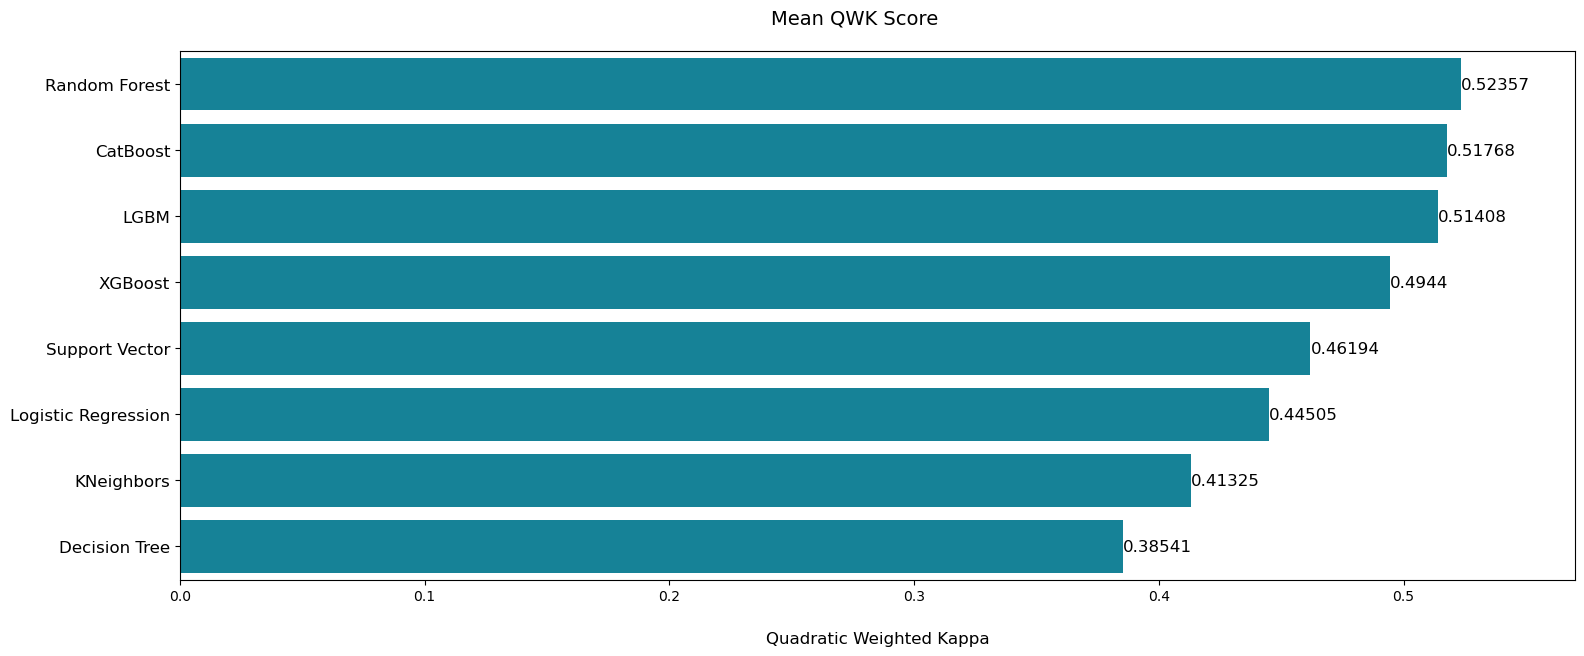

In [28]:
df_kappa = pd.DataFrame(np.round(mean_kappa, 5), index=clf_models.keys()).reset_index()
df_kappa = df_kappa.rename(columns={'index': 'Model', 0 : 'Mean Kappa'})
df_kappa = df_kappa.sort_values(by='Mean Kappa', ascending=False)

fig, ax = plt.subplots(figsize=(18, 7), dpi=100)
fig.suptitle('Mean QWK Score', fontsize=14, y=0.94)
sns.barplot(data=df_kappa, y='Model', x='Mean Kappa', color=colors[0],dodge=False)
ax.xaxis.set_tick_params(labelsize=10)
ax.yaxis.set_tick_params(labelsize=12)
ax.set_xlabel('Quadratic Weighted Kappa', fontsize=12, labelpad=20)
ax.set_ylabel('')
ax.set_xlim([0.0, 0.57])

for i in ax.containers:
    ax.bar_label(i, fontsize=12);

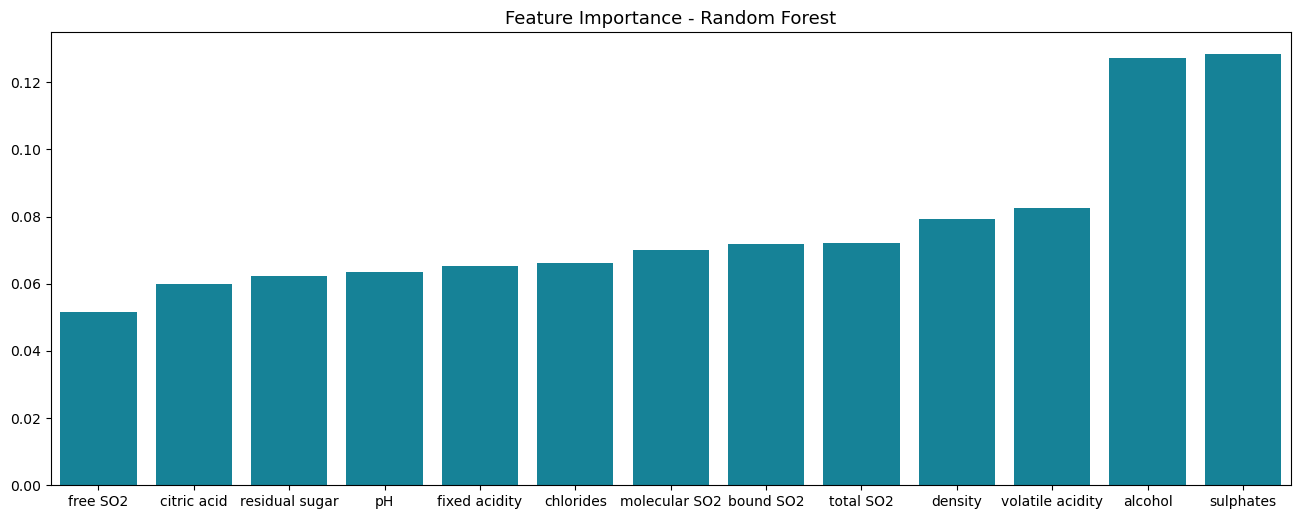

In [29]:
# Feature Importance - RFC
feat_imp_rf = pd.Series(models[4].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_rf.index, y=feat_imp_rf.values, color=colors[0])
plt.title("Feature Importance - Random Forest", fontsize=13);

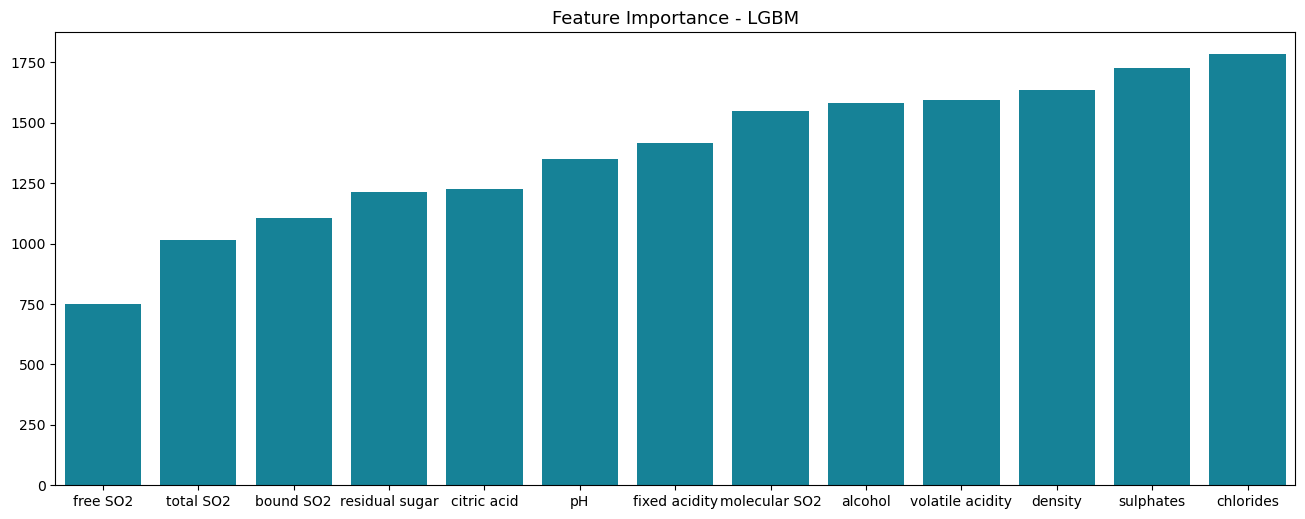

In [30]:
# Feature Importance - LGBM
feat_imp_lgbm = pd.Series(models[6].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_lgbm.index, y=feat_imp_lgbm.values, color=colors[0])
plt.title("Feature Importance - LGBM", fontsize=13);

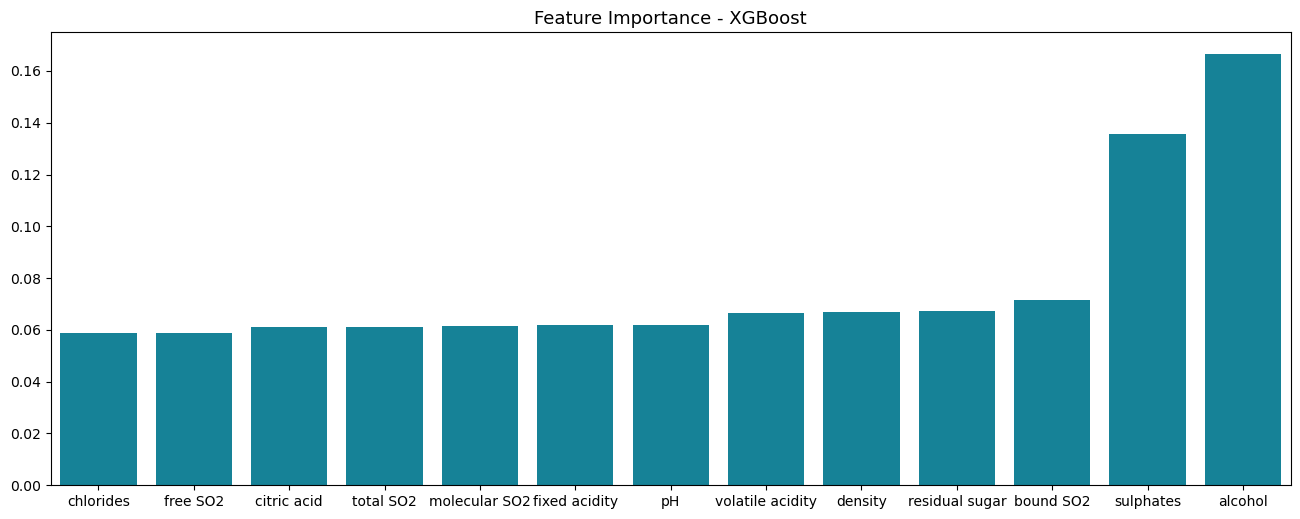

In [31]:
# Feature Importance - XGB
feat_imp_xgb = pd.Series(models[5].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_xgb.index, y=feat_imp_xgb.values, color=colors[0])
plt.title("Feature Importance - XGBoost", fontsize=13);

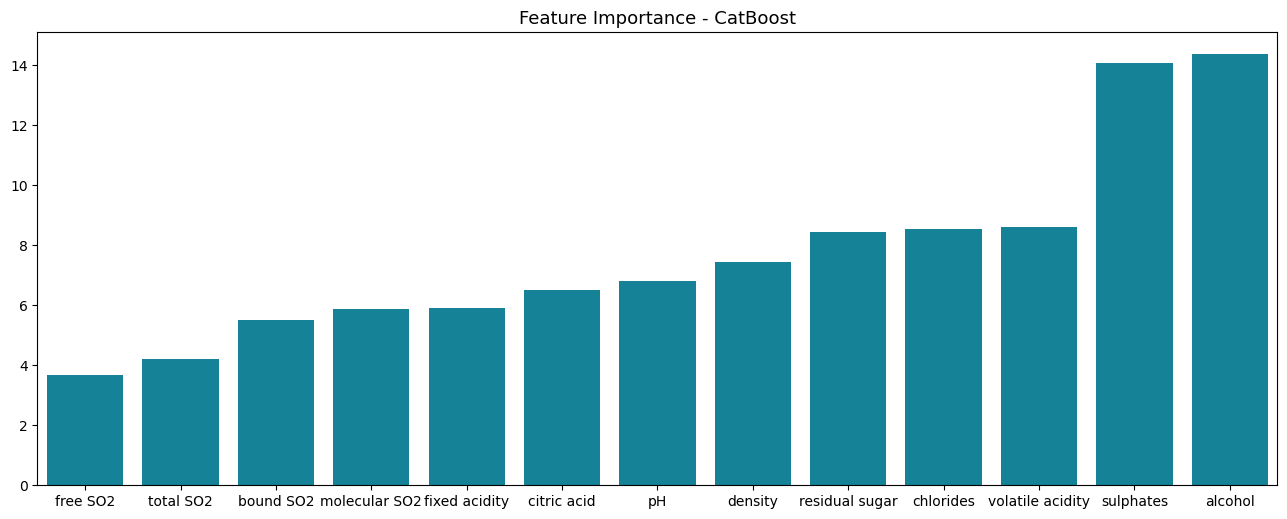

In [32]:
# Feature Importance - CatBoost
feat_imp_cb = pd.Series(models[7].feature_importances_, index=X_train.columns).sort_values()

plt.figure(figsize=(16, 6), dpi=100)
sns.barplot(x=feat_imp_cb.index, y=feat_imp_cb.values, color=colors[0])
plt.title("Feature Importance - CatBoost", fontsize=13);

# Hyperparameter Tuning with Optuna

In [33]:
import optuna
optuna.logging.set_verbosity(optuna.logging.WARNING)

In [34]:
def tune(objective):
    study = optuna.create_study(direction="maximize")
    study.optimize(objective, n_trials=100)

    params = study.best_params
    best_score = study.best_value
    print(f"Best score: {best_score} \nOptimized parameters: {params}")
    return params

In [35]:
def randomforest_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 100, 800)
    _max_depth = trial.suggest_int("max_depth", 3, 12)
    _min_samp_split = trial.suggest_int("min_samples_split", 3, 8)
    _min_samples_leaf = trial.suggest_int("min_samples_leaf", 3, 8)
    #_max_features = trial.suggest_int("max_features", 10, 50)

    rf = RandomForestClassifier(n_estimators=_n_estimators, 
                                max_depth=_max_depth, 
                                min_samples_split=_min_samp_split, 
                                min_samples_leaf=_min_samples_leaf, 
                                n_jobs=-1, 
                                random_state=SEED)

    score = cross_val_score(rf, X_train, y_train, cv=cvfold, scoring=kappa_score).mean()
    
    return score

# randomforest_params = tune(randomforest_objective)

# Best score: 0.5232776775680927 
# Optimized parameters: {'n_estimators': 128, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}

randomforest_params = {'n_estimators': 128, 'max_depth': 12, 'min_samples_split': 3, 'min_samples_leaf': 3}

In [36]:
tuned_rf = RandomForestClassifier(**randomforest_params, random_state=SEED)

In [37]:
def lgbm_objective(trial):
    _n_estimators = trial.suggest_int("n_estimators", 100, 800)
    _num_leaves = trial.suggest_int("num_leaves", 50, 100)
    _max_depth = trial.suggest_int("max_depth", 3, 12)
    _learning_rate = trial.suggest_float("learning_rate", 0.01, 1)
    _min_child_weight = trial.suggest_float("min_child_weight", 0.1, 10)
    
    lgbm = LGBMClassifier(num_leaves=_num_leaves,
                          max_depth=_max_depth,
                          learning_rate=_learning_rate,
                          n_estimators=_n_estimators,
                          min_child_weight=_min_child_weight,
                          random_state=SEED, device='gpu')
    
    score = cross_val_score(lgbm, X_train, y_train, cv=cvfold, scoring=kappa_score).mean()
   
    return score

# lgbm_params = tune(lgbm_objective)

# Best score: 0.5257870744157032 
# Optimized parameters: {'n_estimators': 507, 'num_leaves': 91, 'max_depth': 7, 
#                        'learning_rate': 0.011061356703028463, 'min_child_weight': 0.7002010558154002}

lgbm_params = {'n_estimators': 507, 'num_leaves': 91, 'max_depth': 7, 
               'learning_rate': 0.011061356703028463, 'min_child_weight': 0.7002010558154002}

In [38]:
tuned_lgbm = LGBMClassifier(**lgbm_params, random_state=SEED, device='gpu')

In [39]:
def catboost_objective(trial):
    _iterations=trial.suggest_int("iterations", 100, 1000)
    _learning_rate=trial.suggest_float("learning_rate", 0.001, 0.2)
    _depth=trial.suggest_int("depth", 3, 12)
    _bootstrap_type=trial.suggest_categorical("bootstrap_type", ["Bayesian"])
    _bagging_temperature=trial.suggest_float("bagging_temperature", 0.0, 10.0)
        
    catboost = CatBoostClassifier(iterations=_iterations,
                          learning_rate=_learning_rate,
                          depth=_depth,
                          bootstrap_type=_bootstrap_type,
                          bagging_temperature=_bagging_temperature,
                          random_state=SEED, task_type='GPU', verbose=False)
    
    score = cross_val_score(catboost, X_train, y_train, cv=cvfold, scoring=kappa_score).mean()
   
    return score

# catboost_params = tune(catboost_objective)
# Best score: 0.5456436792907795 
# Optimized parameters: {'iterations': 688, 'learning_rate': 0.05331647943970542, 'depth': 7, 
#                        'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8328519306172799}

catboost_params = {'iterations': 688, 'learning_rate': 0.05331647943970542, 'depth': 7, 
                   'bootstrap_type': 'Bayesian', 'bagging_temperature': 0.8328519306172799}

In [40]:
tuned_catboost = CatBoostClassifier(**catboost_params, random_state=SEED, task_type='GPU', verbose=False)

# Voting Classifier

With voting classifier, we will combine multiple machine learning to make a prediction. Each model predicts the target and the final prediction is based on a weighted average of the predicted probabilities (soft voting). For the voting classifier, we will choose tuned LightGBM, and CatBoost models based on the best kappa score.

In [41]:
voting_tuned_model = VotingClassifier(
    estimators=[('LGBM', tuned_lgbm), ('CatBoost', tuned_catboost)], voting='soft') # ('RFC', tuned_rf), 

voting_tuned_model.fit(X_train, y_train)

VotingClassifier(estimators=[('LGBM',
                              LGBMClassifier(device='gpu',
                                             learning_rate=0.011061356703028463,
                                             max_depth=7,
                                             min_child_weight=0.7002010558154002,
                                             n_estimators=507, num_leaves=91,
                                             random_state=8888)),
                             ('CatBoost',
                              <catboost.core.CatBoostClassifier object at 0x7f757030ff90>)],
                 voting='soft')

In [42]:
# Predict target label on unseen data
y_pred_vt = voting_tuned_model.predict(X_test)

predictions_vt = pd.DataFrame({'Id' : df_test['Id'], 'quality' : y_pred_vt})
predictions_vt['quality'] = predictions_vt['quality'].astype('int') + 3
predictions_vt.head()

,Id,quality
0,2056,6
1,2057,6
2,2058,6
3,2059,6
4,2060,5


In [43]:
output = predictions_vt.to_csv("submission_voting_v1.csv", index=False)